In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # 標籤編碼(Label)、獨熱編碼(OneHot)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [401]:
df_train = pd.read_csv('train.csv'.index_col=0)
df_test = pd.read_csv('test.csv'.index_col=0)
submit = pd.read_csv('gender_submission.csv'.index_col=0)

print( f'train {df_train.shape}' )
display( df_train.head() )

print( f'\ntest {df_test.shape}' )
display( df_test.head() )

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-401-ac206e1cf8d1>, line 1)

In [402]:
df_train.dtypes.to_frame() #確認欄位型態

,0
PassengerId,int64
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64


In [403]:
df_train.isnull().sum() # 計算欄位中缺漏值的數量

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [404]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [405]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [406]:
#將訓練集與測試集合併，方便後續一併修補或調整資料
df_data = df_train.append( df_test )
df_data

#Survival Ratio is imbalanced Data
Survived_Counts = df_data['Survived'].value_counts().reset_index()
Survived_Counts.columns = ['Survived','Counts']
Survived_Counts

,Survived,Counts
0,0.0,549
1,1.0,342


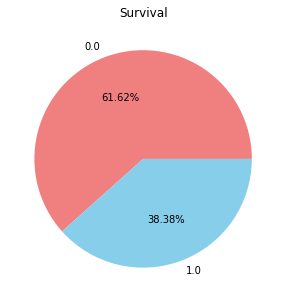

In [407]:
plt.figure( figsize=(10,5) )
df_data['Survived'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title( 'Survival' )  # 圖標題
plt.ylabel( '' )
plt.show()

In [408]:
# Survied 與其他欄位間的相關係數
Corr_Matrix = df_train.corr()  # 計算相關係數
Corr = Corr_Matrix.loc['Survived',:].sort_values()[:-1]
Corr = pd.DataFrame({ 'Survived':Corr })
Corr

,Survived
Pclass,-0.338481
Age,-0.077221
SibSp,-0.035322
PassengerId,-0.005007
Parch,0.081629
Fare,0.257307


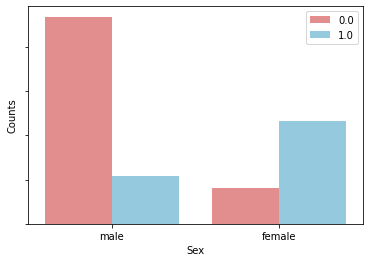

In [409]:
plt.figure()
sns.countplot(x= df_data['Sex'], hue= df_data.Survived, palette=['lightcoral','skyblue'])
plt.subplot().set_yticklabels([])
plt.subplot().set_ylabel('Counts')
plt.subplot().legend(loc=1)

plt.show()

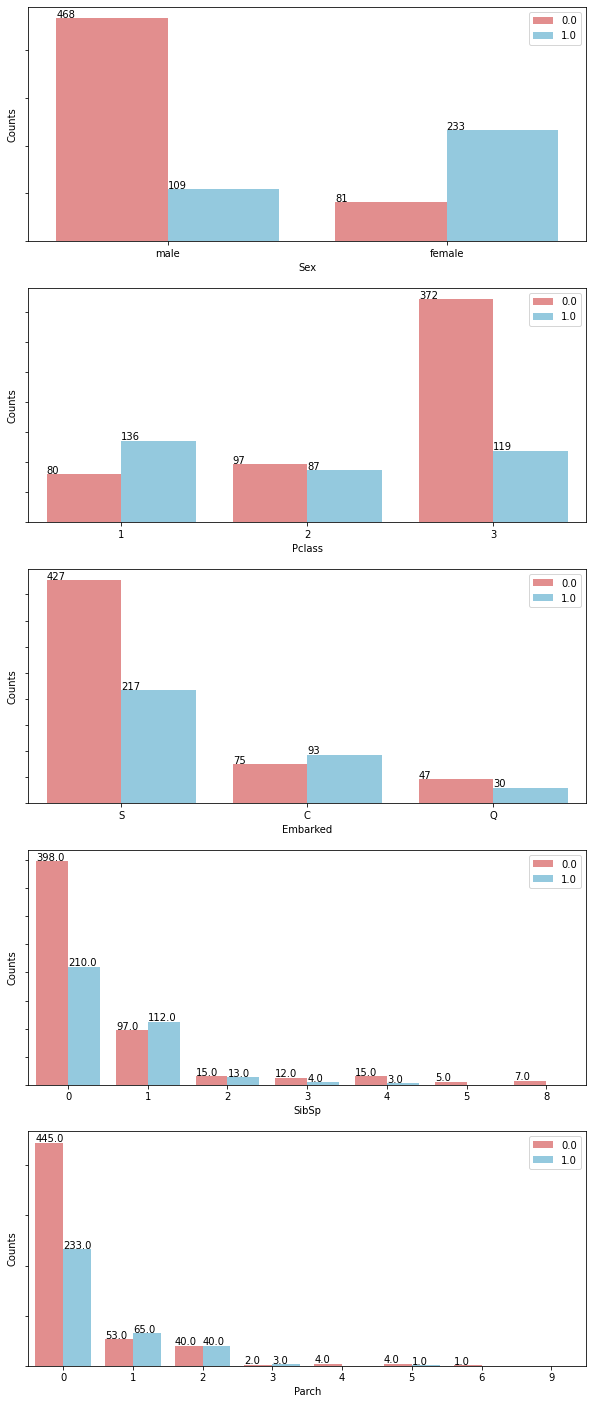

In [410]:
# Survival Rate
# Sex性別、Pclass票務艙、Embarked登船港口、SibSp兄弟姊妹配偶人數、Parch父母子女人數
selected_cols = ['Sex','Pclass','Embarked','SibSp','Parch']

plt.figure(figsize=(10,len(selected_cols)*5))
gs = gridspec.GridSpec(len(selected_cols),1)

for i, col in enumerate(df_data[selected_cols]) :        
    ax = plt.subplot(gs[i])
    sns.countplot(x = df_data[col], hue=df_data.Survived, palette=['lightcoral','skyblue'])
    ax.set_yticklabels([])
    ax.set_ylabel('Counts')
    ax.legend(loc=1)   # upper right:1 ; upper left:2
    for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x(), p.get_height()+1.5))
plt.show()

In [411]:
for col in selected_cols:
    l = ['Survived']
    l.append(col) 
    Survival_Rate = df_data[l].groupby(by=col).mean().round(4).reset_index()
    Survival_Rate.columns = [col,'Survival Rate(%)']
    Survival_Rate['Survival Rate(%)'] = Survival_Rate['Survival Rate(%)'].map( lambda x:x*100 )
    display( Survival_Rate )

,Sex,Survival Rate(%)
0,female,74.20
1,male,18.89


,Pclass,Survival Rate(%)
0,1,62.96
1,2,47.28
2,3,24.24


,Embarked,Survival Rate(%)
0,C,55.36
1,Q,38.96
2,S,33.70


,SibSp,Survival Rate(%)
0,0,34.54
1,1,53.59
2,2,46.43
3,3,25.00
4,4,16.67
5,5,0.00
6,8,0.00


,Parch,Survival Rate(%)
0,0,34.37
1,1,55.08
2,2,50.00
3,3,60.00
4,4,0.00
5,5,20.00
6,6,0.00
7,9,NaN


* 女性的生存率明顯高於男性；
* 票務艙(Pclass)的生存率大小: Pclass 1 > Pclass 2 > Pclasss 3；
* 登船港口(Embarked)的生存率以 C 最高；
* 當船上的兄弟姐妹配偶人數(SibSp)有 1 人同行時，則生存率較高；
* 當船上的父母子女人數(Parch)為 1~3 人時，有較高的生存率。

In [412]:
# 創造新的特徵變數：家庭人數(Family_Size)
df_data['Family_Size'] = df_data['SibSp'] + df_data['Parch'] + 1

Survival_Rate = df_data[['Family_Size','Survived']].groupby(by=['Family_Size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Family_Size,Survival Rate(%)
0,1,30.353818
1,2,55.279503
2,3,57.843137
3,4,72.413793
4,5,20.000000
5,6,13.636364
6,7,33.333333
7,8,0.000000
8,11,0.000000


In [413]:
df_data[ 'Family_Class' ] = np.nan

df_data.loc[ df_data.Family_Size==0, 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=1) & (df_data.Family_Size<=3), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_Size>=4) & (df_data.Family_Size<=6), 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_Size>=7), 'Family_Class' ] = 1

In [414]:
# Sex & Pclass 
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

,Sex,Pclass,Survival Rate(%)
0,female,1,96.808511
1,female,2,92.105263
2,female,3,50.000000
3,male,1,36.885246
4,male,2,15.740741
5,male,3,13.544669


In [415]:
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==1), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==2), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='female') & (df_data.Pclass==3), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==1), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==2), 'Sex_Pclass' ] = 1
df_data.loc[ (df_data.Sex=='male') & (df_data.Pclass==3), 'Sex_Pclass' ] = 2

In [416]:
# 特徵工程(Feature Engineering)
# Name (姓名)
# Method 1: split()
df_data['Title'] = df_data.Name.str.split(', ', expand=True)[1]
df_data['Title'] = df_data.Title.str.split('.', expand=True)[0]
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [417]:
# Method 2: 正規表示法(Regular Expression)
import re

regex = re.compile( ' ([A-Za-z]+)\.' )  
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )  
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [418]:
df_data['Title'] = df_data.Title.replace( ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace( ['Ms','Mlle'], 'Miss' )
df_data['Title'] = df_data.Title.replace( 'Mme', 'Mrs' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [419]:
# 刪除原始資料中的 Name 欄位 
df_data.drop('Name', axis=1, inplace=True)

In [420]:
# 船票號碼(Ticket)
# 假設 Ticket 中，前面英文字母的部份代表房間位於相同的區域中
df_data['Ticket_info'] = df_data.Ticket.apply(lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [421]:
# 刪除原始資料中的 Ticket 欄位 
df_data.drop('Ticket', axis=1, inplace=True)

In [422]:
# 填補缺漏值(Missing Values)
# 定義用來統計欄位缺漏值總數的函數
def Missing_Counts( Data ) : 
    missing = Data.isnull().sum()  # 計算欄位中缺漏值的數量 
    missing = missing[ missing>0 ]
    missing.sort_values( inplace=True ) 
    
    Missing_Count = pd.DataFrame( { 'ColumnName':missing.index, 'MissingCount':missing.values } )  # Convert Series to DataFrame
    Missing_Count[ 'Percentage(%)' ] = Missing_Count['MissingCount'].apply( lambda x:round(x/Data.shape[0]*100,2) )
    return  Missing_Count


Missing_Counts(df_data.drop('Survived', axis=1))

,ColumnName,MissingCount,Percentage(%)
0,Fare,1,0.08
1,Embarked,2,0.15
2,Age,263,20.09
3,Cabin,1014,77.46


In [423]:
#票價(Fare) : 填補整體票價的中位數
df_data['Fare'].fillna(df_data.Fare.median(), inplace=True)

In [424]:
#登船港口(Embarked) : 填補次數最多的港口 'S'
# 計算 Embarked 欄位中每個相異值的次數
display( df_data['Embarked'].value_counts() )
# 填補 Embarked 欄位的缺漏值
df_data['Embarked'].fillna( 'S', inplace=True )

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [425]:
#年齡(Age)
# 新增標註 Age 欄位是否為缺漏值的欄位(有缺漏標為0)
df_data['isAge'] = df_data['Age'].isnull().map( lambda x:0 if x==True else 1 )

In [426]:
# 分別觀察 Age 與 Sex、Pclass 的缺漏值分布狀況
display(pd.crosstab(df_data.isAge, df_data.Sex, margins=True))
display(pd.crosstab(df_data.isAge, df_data.Pclass, margins=True))

Sex,female,male,All
isAge,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


Pclass,1,2,3,All
isAge,,,,
0,39,16,208,263
1,284,261,501,1046
All,323,277,709,1309


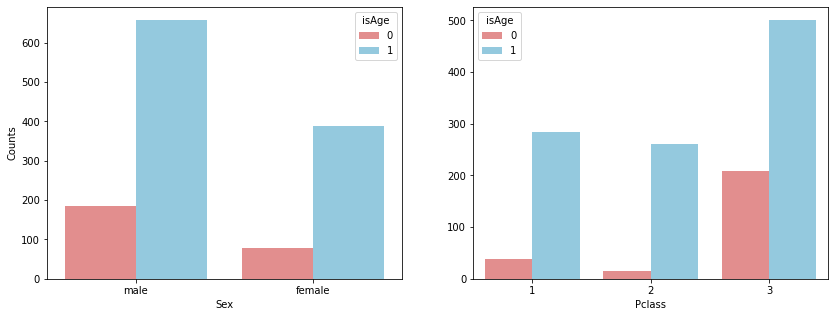

In [427]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
#plt.suptitle('Age')

plt.subplot(1,2,1)
sns.countplot(x= df_data.Sex, hue=df_data.isAge, palette=['lightcoral','skyblue'])
plt.ylabel('Counts') 

plt.subplot(1,2,2)
sns.countplot(x= df_data.Pclass, hue=df_data.isAge, palette=['lightcoral','skyblue'])
plt.ylabel('') 

plt.show()

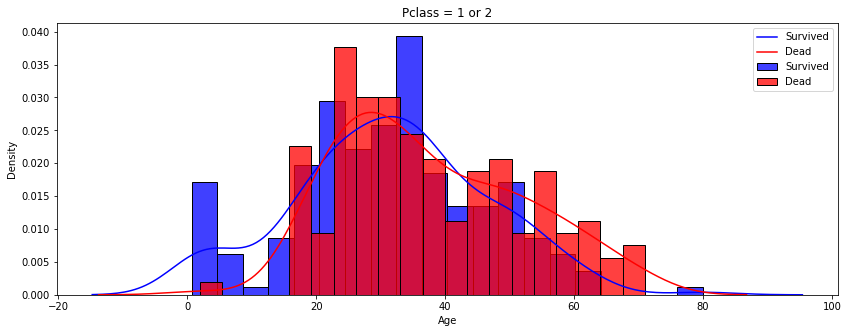

In [428]:
'''
經觀察上表及圖後可知，
Age 欄位的缺漏值明顯分佈在 Pclass 3 中，
約佔 29.34%(=208/709)，
進一步觀察在 Pclass 1 及 Pclass 2 的乘客中，
Age 欄位對於存活率是否有明顯的影響？
'''
index_S = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==1)
index_D = (df_data.isAge==1)&(df_data.Pclass!=3)&(df_data.Survived==0)

plt.figure(figsize=(14,5))
sns.histplot(x= df_data.loc[index_S,'Age'], bins=20, color='blue', label='Survived', stat='density')
sns.kdeplot(x= df_data.loc[index_S,'Age'], color='blue', label='Survived')

sns.histplot(x= df_data.loc[index_D,'Age'], bins=20, color='red', label='Dead', stat='density')
sns.kdeplot(x= df_data.loc[index_D,'Age'], color='red', label='Dead')
plt.title('Pclass = 1 or 2')
plt.legend()
plt.show()

In [429]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Master,4.0
1,Miss,22.0
2,Mr,29.0
3,Mrs,35.0
4,Rare,47.5


,Title,Age Mean
0,Master,5.482642
1,Miss,21.824366
2,Mr,32.252151
3,Mrs,36.918129
4,Rare,45.178571


In [430]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][4]

# 刪除 isAge 欄位 
df_data.drop( 'isAge', axis=1, inplace=True )

In [431]:
# 填滿 Age 欄位的缺漏值後，我們將年齡特徵再區分成未滿17歲及17歲以上，未滿17歲的乘客標為1，17歲以上的乘客標為0。
# 乘客年齡是否未滿17歲(是：1；否：0)
df_data[ 'is_Age_17' ] = (df_data.Age<17)*1
df_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17
0,1,0.0,3,male,22.000000,1,0,7.2500,NaN,S,2,3.0,2.0,Mr,A5,0
1,2,1.0,1,female,38.000000,1,0,71.2833,C85,C,2,3.0,2.0,Mrs,PC,0
2,3,1.0,3,female,26.000000,0,0,7.9250,NaN,S,1,3.0,3.0,Miss,STONO2,0
3,4,1.0,1,female,35.000000,1,0,53.1000,C123,S,2,3.0,2.0,Mrs,X,0
4,5,0.0,3,male,35.000000,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,A5,0
414,1306,NaN,1,female,39.000000,0,0,108.9000,C105,C,1,3.0,2.0,Rare,PC,0
415,1307,NaN,3,male,38.500000,0,0,7.2500,NaN,S,1,3.0,2.0,Mr,SOTONOQ,0
416,1308,NaN,3,male,32.252151,0,0,8.0500,NaN,S,1,3.0,2.0,Mr,X,0


In [432]:
#船艙號碼(Cabin)
# 觀察 Cabin 中的種類
df_data['Cabin'].unique()
# 取出 Cabin 中的第一個字母，如果為缺漏值，則以 NoCabin 表示
df_data['Cabin'] = df_data['Cabin'].apply( lambda x:str(x)[0] if not pd.isnull(x) else 'NoCabin' )
df_data['Cabin'].unique()

array(['NoCabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [433]:
#在完成上述缺漏值的填補後，我們再次檢查是否還有缺漏值尚未填補到。
Missing_Counts( df_data.drop('Survived', axis=1) )

,ColumnName,MissingCount,Percentage(%)


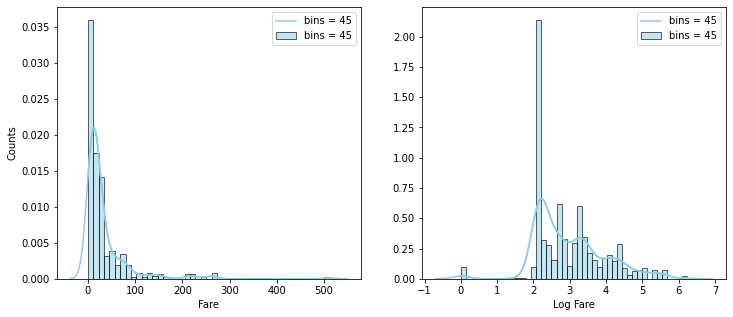

In [434]:
#離群值(Outlier)
#乘客票價(Fare) 
# 對 Fare 欄位取對數
df_data['LogFare'] = np.log1p( df_data.Fare )

# 直方圖(Histogram)
fig, axs = plt.subplots( 1,2,figsize=(12,5) )

plt.subplot( 1,2,1 )
sns.histplot(df_data.Fare, kde=True, bins=45, color='skyblue', label='bins = 45', stat='density')
sns.kdeplot(df_data.Fare, color='skyblue', label='bins = 45')
plt.xlabel( 'Fare' ) 
plt.ylabel( 'Counts' ) 
plt.legend( )

plt.subplot( 1,2,2 )
sns.histplot(df_data.LogFare, kde=True, bins=45, color='skyblue', label='bins = 45', stat='density')
sns.kdeplot(df_data.LogFare, color='skyblue', label='bins = 45')
plt.xlabel( 'Log Fare' ) 
plt.ylabel( '' ) 
plt.legend( )

plt.show()

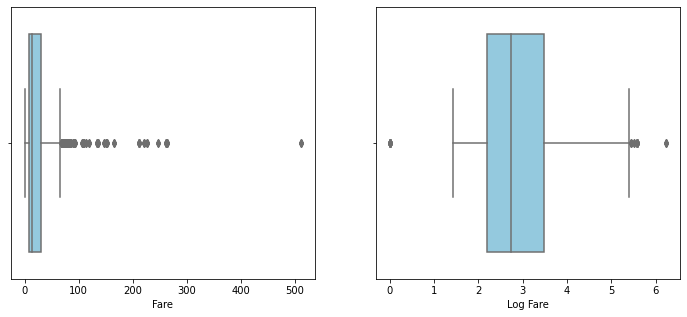

In [435]:
# 盒鬚圖(Box Plot)
fig, axs = plt.subplots(1,2,figsize=(12,5))

plt.subplot( 1,2,1 )
sns.boxplot(x= df_data.Fare, orient='h', color='skyblue')
plt.xlabel('Fare') 

plt.subplot(1,2,2)
sns.boxplot(x= df_data.LogFare, orient='h', color='skyblue')
plt.xlabel('Log Fare') 

plt.show()

In [436]:
# 計算 Fare 欄位各個百分位數(Percentile)
P_all = [ np.percentile( df_data.Fare, q=i ) for i in np.arange(0,101) ] 
Pth_Percentile = pd.DataFrame( { 'Q':list(range(101)), 'Value':P_all } )

# The first、second and third quartile(i,e., the 25th、50th and 75th Percentile)
Q1 = Pth_Percentile.iloc[ 25, 1 ]
Q2 = Pth_Percentile.iloc[ 50, 1 ]
Q3 = Pth_Percentile.iloc[ 75, 1 ]
IQR = Q3 - Q1

print( f'Q1 = {Q1}' )
print( f'Q2 = {Q2} = Median' )
print( f'Q3 = {Q3}' )
print( f'Maximum = {df_data.Fare.max()}')
print( f'IQR = Q3 - Q1 = {IQR}' )
print( f'Q3 + 1.5IQR = {Q3+1.5*IQR}' )

# 依照四分位數，對 Fare 欄位進行分組
Fare_bin = [ 0, Q1, Q2, Q3, Q3+1.5*IQR, df_data.Fare.max() ]
df_data[ 'Fare_Group' ] = pd.cut( df_data.Fare.values, Fare_bin )

# 計算每個分組中的資料筆數
Group_Counts = df_data[ 'Fare_Group' ].value_counts().reset_index()    
Group_Counts.columns = [ 'Fare_Group', 'Counts' ]
Group_Counts.sort_values( by='Fare_Group' )

Q1 = 7.8958
Q2 = 14.4542 = Median
Q3 = 31.275
Maximum = 512.3292
IQR = Q3 - Q1 = 23.379199999999997
Q3 + 1.5IQR = 66.34379999999999


,Fare_Group,Counts
2,"(0.0, 7.896]",320
1,"(7.896, 14.454]",321
0,"(14.454, 31.275]",328
4,"(31.275, 66.344]",152
3,"(66.344, 512.329]",171


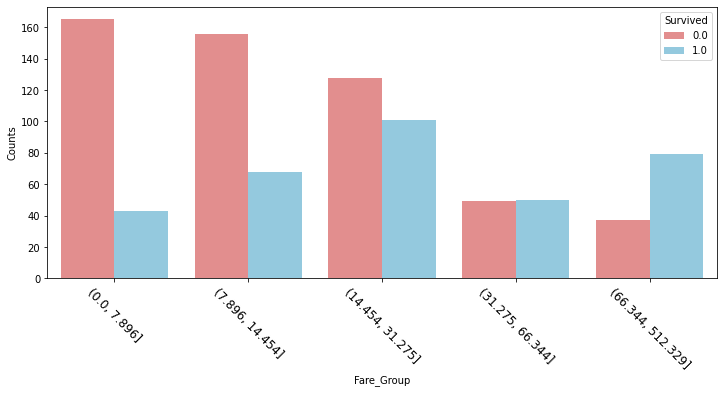

In [437]:
plt.subplots( figsize=(12,5) )
sns.countplot(x= df_data.Fare_Group, hue=df_data.Survived, palette=['lightcoral','skyblue'] )
plt.ylabel( 'Counts' ) 
plt.xticks( rotation=-45, fontsize=12 )
plt.show()

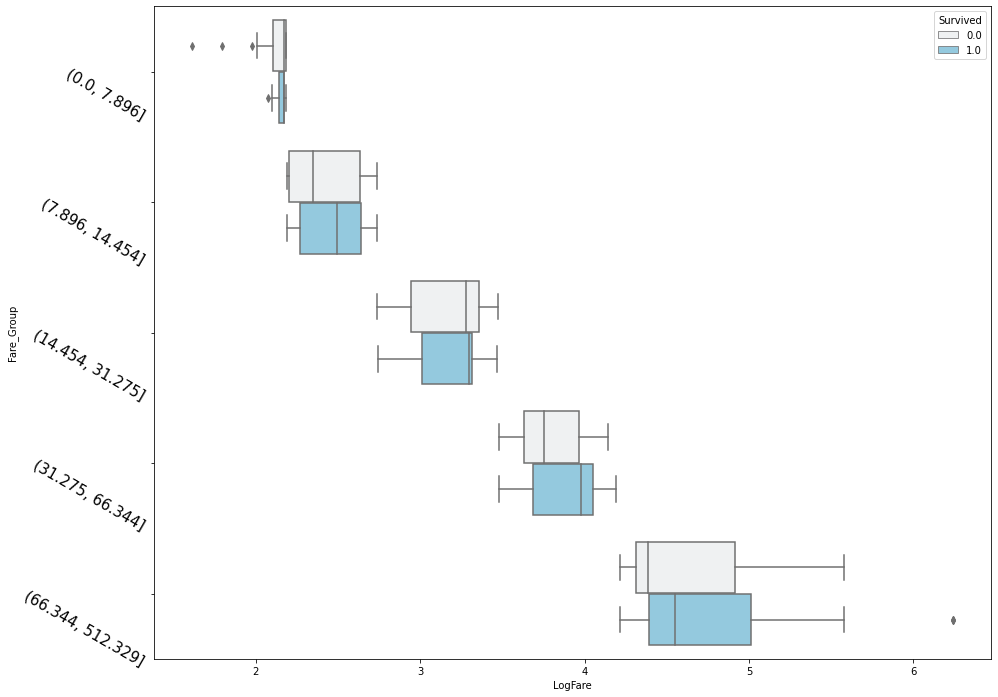

In [438]:
plt.subplots( figsize=(15,12) )
sns.boxplot( x='LogFare', y='Fare_Group', data=df_data, hue='Survived', orient='h', color='skyblue' )
plt.yticks( rotation=-30, fontsize=15 )
plt.show()

In [439]:
# 刪除 Fare_Group 欄位 
df_data.drop( ['Fare','Fare_Group'], axis=1, inplace=True )

In [440]:
#獨熱編碼(OneHot Encoding)、標籤編碼(Label Encoding)

#登船港口(Embarked)
# OneHot Encoding
OneHot_Embarked = pd.get_dummies( df_data.Embarked, prefix='Embarked' )

# 合併 Embarked 編碼後的欄位
df_data = pd.concat( [ df_data, OneHot_Embarked ], axis=1 )
df_data.drop( 'Embarked', axis=1, inplace=True )

In [441]:
#性別(Sex)
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

In [442]:
#訓練集(Train)與測試集(Test)
# 檢視特徵工程後的資料
print( f'Shape of data after feature engineering = {df_data.shape}' )
df_data.head()

Shape of data after feature engineering = (1309, 18)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,NoCabin,2,3.0,2.0,Mr,A5,0,2.110213,0,0,1
1,2,1.0,1,1,38.0,1,0,C,2,3.0,2.0,Mrs,PC,0,4.280593,1,0,0
2,3,1.0,3,1,26.0,0,0,NoCabin,1,3.0,3.0,Miss,STONO2,0,2.188856,0,0,1
3,4,1.0,1,1,35.0,1,0,C,2,3.0,2.0,Mrs,X,0,3.990834,0,0,1
4,5,0.0,3,0,35.0,0,0,NoCabin,1,3.0,2.0,Mr,X,0,2.202765,0,0,1


In [443]:
#類別型態欄位轉為整數
for col in ['Title','Ticket_info','Cabin']:
    df_data[col] = df_data[col].astype('category').cat.codes

df_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.0,1,0,7,2,3.0,2.0,2,2,0,2.110213,0,0,1
1,2,1.0,1,1,38.0,1,0,2,2,3.0,2.0,3,14,0,4.280593,1,0,0
2,3,1.0,3,1,26.0,0,0,7,1,3.0,3.0,1,31,0,2.188856,0,0,1
3,4,1.0,1,1,35.0,1,0,2,2,3.0,2.0,3,36,0,3.990834,0,0,1
4,5,0.0,3,0,35.0,0,0,7,1,3.0,2.0,2,36,0,2.202765,0,0,1


In [444]:
#產生訓練集(Train)與測試集(Test)
# 產生訓練集和測試集
Train = df_data[pd.notnull(df_data.Survived)]
Train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,0,22.000000,1,0,7,2,3.0,2.0,2,2,0,2.110213,0,0,1
1,2,1.0,1,1,38.000000,1,0,2,2,3.0,2.0,3,14,0,4.280593,1,0,0
2,3,1.0,3,1,26.000000,0,0,7,1,3.0,3.0,1,31,0,2.188856,0,0,1
3,4,1.0,1,1,35.000000,1,0,2,2,3.0,2.0,3,36,0,3.990834,0,0,1
4,5,0.0,3,0,35.000000,0,0,7,1,3.0,2.0,2,36,0,2.202765,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,0,27.000000,0,0,7,1,3.0,1.0,4,36,0,2.639057,0,0,1
887,888,1.0,1,1,19.000000,0,0,1,1,3.0,2.0,1,36,0,3.433987,0,0,1
888,889,0.0,3,1,21.824366,1,2,7,4,2.0,3.0,1,34,0,3.196630,0,0,1
889,890,1.0,1,0,26.000000,0,0,2,1,3.0,1.0,2,36,0,3.433987,1,0,0


In [445]:
Test = df_data[ pd.isnull(df_data.Survived)]
Test

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Family_Size,Family_Class,Sex_Pclass,Title,Ticket_info,is_Age_17,LogFare,Embarked_C,Embarked_Q,Embarked_S
0,892,NaN,3,0,34.500000,0,0,7,1,3.0,2.0,2,36,0,2.178064,0,1,0
1,893,NaN,3,1,47.000000,1,0,7,2,3.0,3.0,3,36,0,2.079442,0,0,1
2,894,NaN,2,0,62.000000,0,0,7,1,3.0,1.0,2,36,0,2.369075,0,1,0
3,895,NaN,3,0,27.000000,0,0,7,1,3.0,2.0,2,36,0,2.268252,0,0,1
4,896,NaN,3,1,22.000000,1,1,7,3,3.0,3.0,3,36,0,2.586824,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,32.252151,0,0,7,1,3.0,2.0,2,2,0,2.202765,0,0,1
414,1306,NaN,1,1,39.000000,0,0,2,1,3.0,2.0,4,14,0,4.699571,1,0,0
415,1307,NaN,3,0,38.500000,0,0,7,1,3.0,2.0,2,28,0,2.110213,0,0,1
416,1308,NaN,3,0,32.252151,0,0,7,1,3.0,2.0,2,36,0,2.202765,0,0,1


In [446]:
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
# 訓練集刪除 PassengerId 欄位；
# 測試集刪除 PassengerId 與 Survived 欄位
Train.drop( ['PassengerId'], axis=1, inplace=True )
Test.drop( ['PassengerId','Survived'], axis=1, inplace=True )

In [447]:
Y_Train = Train.Survived
X_Train = Train.drop( ['Survived'], axis=1 )

In [448]:
#特徵重要性
# 建立決策樹模型
DTC = RandomForestClassifier( )
# 自變數、應變數進行擬合
DTC.fit( X_Train, Y_Train )

# 排序特徵重要性(由大到小)
col_names = X_Train.columns
importances = DTC.feature_importances_
Feature_Rank = pd.DataFrame( { 'Feature_Name':col_names, 'Importance':importances } )
Feature_Rank.sort_values( by='Importance', ascending=False, inplace=True ) 
Feature_Rank

,Feature_Name,Importance
2,Age,0.189408
12,LogFare,0.189319
1,Sex,0.168541
9,Title,0.072341
0,Pclass,0.067981
8,Sex_Pclass,0.066032
5,Cabin,0.053058
6,Family_Size,0.047041
10,Ticket_info,0.040369
3,SibSp,0.032083


In [449]:
#建立模型
# 隨機森林參數：
# n_estimators: 樹的數量(default=10)。
# min_samples_leaf: 最終葉節點最少樣本數(default=1)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# min_samples_split:節點再劃分時所需的最小樣本數(default=2)；
#                   當樣本不大時，可不設定使用預設，若樣本數量非常大時，則推薦增加此參數值。
# oob_score: 是否採用袋外樣本(out-of-bag samples)來評估模型的準確度(default=False)。

RFC = RandomForestClassifier( n_estimators = 1000,
                              min_samples_split = 20,
                              min_samples_leaf = 1,
                              oob_score = True,
                              random_state = 1,
                              n_jobs = -1 )

In [450]:
# 訓練模型
RFC.fit( X_Train, Y_Train )
print( 'oob_score = {:.6f}'.format(RFC.oob_score_))

oob_score = 0.828283


In [451]:
RFC_2 = RandomForestClassifier( n_estimators = 1000,
                                min_samples_split = 20,
                                min_samples_leaf = 1,
                                oob_score = True,
                                random_state = 1,
                                n_jobs = -1 ) 

# 篩選部份特徵欄位餵入模型進行訓練
SelectedFeatures = ['Age','Sex','LogFare','Title','Pclass','Sex_Pclass']
RFC_2.fit( X_Train[SelectedFeatures], Y_Train )

print( f'Selected Features :\n   {SelectedFeatures}' )
print( 'oob_score = {:.6f}'.format(RFC_2.oob_score_) )

Selected Features :
   ['Age', 'Sex', 'LogFare', 'Title', 'Pclass', 'Sex_Pclass']
oob_score = 0.843996


In [453]:
# 預測測試集資料
Test_pred = RFC_2.predict( Test[SelectedFeatures] )

# 檢視預測罹難或生還的機率
print( RFC_2.predict_proba(Test[SelectedFeatures]) )


[[0.96012773 0.03987227]
 [0.5628299  0.4371701 ]
 [0.77060386 0.22939614]
 [0.739381   0.260619  ]
 [0.32734005 0.67265995]
 [0.88396377 0.11603623]
 [0.63063996 0.36936004]
 [0.89729214 0.10270786]
 [0.27615042 0.72384958]
 [0.89623454 0.10376546]
 [0.99108434 0.00891566]
 [0.84590615 0.15409385]
 [0.05035885 0.94964115]
 [0.86196487 0.13803513]
 [0.00725277 0.99274723]
 [0.08805559 0.91194441]
 [0.89418773 0.10581227]
 [0.79941876 0.20058124]
 [0.47225115 0.52774885]
 [0.56201797 0.43798203]
 [0.82541322 0.17458678]
 [0.44599848 0.55400152]
 [0.03582145 0.96417855]
 [0.64212557 0.35787443]
 [0.06874394 0.93125606]
 [0.91673673 0.08326327]
 [0.01480145 0.98519855]
 [0.80311873 0.19688127]
 [0.52404938 0.47595062]
 [0.92551925 0.07448075]
 [0.95300238 0.04699762]
 [0.92935974 0.07064026]
 [0.36234907 0.63765093]
 [0.50990431 0.49009569]
 [0.60382412 0.39617588]
 [0.8873627  0.1126373 ]
 [0.63611508 0.36388492]
 [0.73363812 0.26636188]
 [0.90538914 0.09461086]
 [0.6028294  0.3971706 ]
